In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import math
import numpy as np
import pandas as pd
import time
import string
import random
import sys
from logger import Logger
from abc import ABC
from datetime import timedelta
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
#from selection_strategy    import RandomSelectionStrategy
sys.path.insert(0,os.pardir)
from ga_inverse import readData
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
import matplotlib.animation as animation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostRegressor
from scipy.spatial.distance import cdist
import seaborn as sns


In [3]:
from abc import ABC

class SelectionStrategy(ABC):
    def select_next_instance():
        pass

class RandomSelectionStrategy(SelectionStrategy):
    def __init__(self):
        pass
        #self.logPrefix = "Random Selection Strategy"

    def select_next_instance(self, candidate_instances: pd.DataFrame):
        selected = np.random.choice(candidate_instances, size=1, replace=False)[0]
        #self.logger.info(self.logPrefix, "Randomly Selected Zif: " + selected)
        return selected   

In [4]:
def plot_data_exists(data_path) -> bool:

    """ Check wheather plot data already exist and return the respective truth value.
        data_path1:     The path to look for the set of data."""

    if not os.path.exists(data_path):
        return False

    return True

def data_preparation(sourceFile=None, research_data="zifs_diffusivity") -> list:

    Y = []
    X = []

    if research_data == "zifs_diffusivity":
        if sourceFile is not None:
            data_from_file = readData(sourceFile)
        else:
            data_from_file = readData()

        Y = ["logD"]
        X = ['diameter','mass','ascentricF', 'kdiameter','ionicRad',
            'MetalNum','MetalMass','σ_1', 'e_1',
            'linker_length1', 'linker_length2', 'linker_length3',
            'linker_mass1', 'linker_mass2', 'linker_mass3',
            'func1_length', 'func2_length', 'func3_length', 
            'func1_mass', 'func2_mass', 'func3_mass']
    
    elif research_data == "co2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2_working_capacity(mol/kg)':'working_capacity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["working_capacity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]

    elif research_data == "co2/n2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2/N2_selectivity':'selectivity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["selectivity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]    

    elif research_data == "o2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofO2cm2s"] = np.log(data_from_file["SelfdiffusionofO2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofO2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "n2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofN2cm2s"] = np.log(data_from_file["SelfdiffusionofN2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofN2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'         

    elif research_data == "ch4":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_CH4 (cm2/s)"] = np.log(data_from_file["D_CH4 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_CH4 (cm2/s)':'logSelfD','MOF name': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU','U_CH4 (mol/kg)']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    else:
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={' absolute methane uptake high P [v STP/v]':'methane_uptake', ' name':'type'})        

        Y = ['methane_uptake']
        X = ['dimensions', ' supercell volume [A^3]', ' density [kg/m^3]',
             ' surface area [m^2/g]', ' num carbon', ' num hydrogen',
             ' num nitrogen', ' num oxygen', ' num sulfur', ' num silicon',
             ' vertices', ' edges', ' genus', ' largest included sphere diameter [A]',
             ' largest free sphere diameter [A]', ' largest included sphere along free sphere path diameter [A]']

    return data_from_file, X, Y

In [5]:
#np_data, featureNames, targetNames = data_preparation("../train_data/train_zifs_diffusivity/TrainData.xlsx")
np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Methane.csv",research_data = "ch4")

# Instantiate the XGB regressor model
XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=6410 ) #,device = "cuda"

#gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))

In [6]:
### Bootstraping for estimating confidence 
def train_ensemble(X, y, n_models=10):
    models = []
    for i in range(n_models):
        # Bootstrap sampling
        X_sample, y_sample = resample(X, y)
        model = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=(6410))
        model.fit(X_sample, y_sample.ravel())
        models.append(model)
    return models

def predict_with_ensemble(models, X):
    predictions = np.array([model.predict(X) for model in models])
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

def uncertainty_sampling(models, X_unlabeled,fefeatureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    _, std_prediction = predict_with_ensemble(models, x_unlabeled)
    # Select the top k most uncertain samples
    #uncertain_indices = std_prediction.argsort()[-k:]
    return std_prediction #uncertain_indices

In [7]:
### GP uncertainty
def Gp_uncertainty(X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    # Define GP surrogate
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred, y_std = gp_model.predict(x_unlabeled,return_std=True)

    #y_std_mean = np.mean(y_std)
    #y_std  = np.abs(y_std - y_std_mean)
    uncertainties = y_std #.argsort()[-1:]
    return uncertainties

In [8]:
def Greedy_AL(model,X_train,y_train,X_unlabeled,featureNames):
   x_unlabeled = X_unlabeled[featureNames].to_numpy()  
   y_pred = model.predict(x_unlabeled)
   
   dist = []
   for y_ul in y_pred:
      dist_ul = np.sqrt((y_ul-y_train)**2)
      
      dist_ul = np.sort(dist_ul)
      dist.append(dist_ul[0])

   return dist      

In [9]:
def qbc(model,X_train,y_train,X_unlabeled,featureNames,targetNames,iter):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred1, y_std = gp_model.predict(x_unlabeled,return_std=True)

    # catb = CatBoostRegressor(depth=5,learning_rate=0.2,l2_leaf_reg=2,iterations=200,task_type="CPU",logging_level='Silent')
    # catb.fit(X_train,y_train.ravel())
    # y_pred4 = catb.predict(x_unlabeled)

    y_pred2 = model.predict(x_unlabeled)

    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train,y_train.ravel())

    y_pred3 = regr.predict(x_unlabeled)

    d1 = np.sqrt((y_pred1-y_pred2)**2)
    d2 = np.sqrt((y_pred1-y_pred3)**2)
    #d3 = np.sqrt((y_pred1-y_pred4)**2)
    d4 = np.sqrt((y_pred2-y_pred3)**2) 
    #d5 = np.sqrt((y_pred2-y_pred4)**2) 
    #d6 = np.sqrt((y_pred3-y_pred4)**2) 


    res = (d1 + d2 + d4 )/3
    # y_unlabeled = X_unlabeled[targetNames].to_numpy()
    # element_mae = np.abs(y_pred2-y_unlabeled.ravel())
    
    # mae_train = predictor(X_train,y_train, X_unlabeled,featureNames, model)
    # est_mae = uncertainty_predictor(X_train, mae_train, X_unlabeled, featureNames, model)

    # min_est_mae = np.min(est_mae)
    mean_unc = np.mean(res)
    
    # #bool_mae_true = element_mae < (mean_est_mae * 0.1)
    #bool_mae = est_mae < (min_est_mae * 0.5) 

    #bool_unc = res < (mean_unc * 0.05)
    bool_unc = res == np.min(res)
    #bool_mae = est_mae == min_est_mae

    # combined_bool_array = np.logical_and(bool_mae, bool_unc)
    # count1 = np.sum(combined_bool_array)
    count2 = np.sum(bool_unc)
    # count3 = np.sum(bool_mae)
    # print("MAE & UNC",count1)
    print("UNC",count2)
    # print("MAE",count3)
    # print("Mean MAE",min_est_mae)
    # print("Min MAE",np.min(est_mae))
    # if(iter<40):
    #     return res, bool_unc
    # else:
    #     return res, combined_bool_array   
    
    return res , bool_unc #combined_bool_array #, combined_bool_array#bool_unc#(np.sqrt((y_pred2-y_pred1)**2))


In [10]:
def select_max_y(model,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    y_pred = model.predict(x_unlabeled)
    return y_pred

In [11]:
def predictor (train_x, train_y, test_x, featureNames ,model):
                    
    #Training
    train_y_model=model.fit(train_x,train_y.ravel())

    #predict_y=model.predict(X)
    
    # #Uncertainty prediction on test data set
    # predict_y_errror=model.predict(test_x)
    # predict_y4Sub=np.reshape(predict_y_errror, (test_x.shape[0],1))
    # uncertainty_test=np.absolute(np.subtract(predict_y4Sub, test_y))

    ##Uncertainty train estimation
    train_y_uns=model.predict(train_x)
    #train_y_uns4sub=np.reshape(train_y_uns, (train_x.shape[0],1))
    uncertainty_train=np.absolute(train_y_uns-train_y.ravel())
    uncertainty_train_norm=np.absolute((uncertainty_train/train_y.ravel()))

    return uncertainty_train #predict_y, , uncertainty_test


def uncertainty_predictor (train_x, train_y, test_x, featureNames,model):
    
    #define cross-validation method to use
    #cv = LeaveOneOut()

    #use LOOCV to evaluate model
    #train_y_CV = cross_val_predict(model, train_x, train_y.ravel(), cv=cv)

    train_y_model=model.fit(train_x,train_y)

    test_X = test_x[featureNames].to_numpy()
    predict_unc=np.absolute(model.predict(test_X))

    return predict_unc


In [12]:
def find_nearest_sample(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Compute the pairwise Euclidean distances between each unlabeled sample and all training samples
    distances = cdist(x_unlabeled, X_train, metric='euclidean')
    
    # Find the minimum distance and the corresponding index
    min_distances = np.mean(distances, axis=1)
    nearest_sample_index = np.argmin(min_distances)
    
    # Return the nearest unlabeled sample, the corresponding distance, and index
    nearest_sample = X_unlabeled.iloc[nearest_sample_index]
    nearest_distance = min_distances[nearest_sample_index]
    return  nearest_sample_index #nearest_sample #, nearest_distance, nearest_sample_index

In [22]:
class OptimizationFactory(ABC):
    def optimizeModel():
        pass

class ActiveLearning(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, bo_selection : str, save_path : str) -> pd.DataFrame:
        

        np.random.seed(10)
        optimization_start_time = time.time()

        # Make a list with all unique ZIF names.
        uniqueZIFs = zifs.type.unique()

        # Initialize dictionary of errors per training data size

        fold_num = 10
        design_space = (len(uniqueZIFs))
        fold_design_space = len(uniqueZIFs) * ((fold_num - 1) / fold_num)

        select_data_points_num = 0
        if design_space < designspace_thres:
            fold_num = len(uniqueZIFs)
            select_data_points_num = len(uniqueZIFs) - 1

        elif fold_design_space < designspace_thres:
            select_data_points_num = int(fold_design_space)

        else:
            select_data_points_num = designspace_thres

        # print(design_space)
        # print(fold_design_space)
        # print(select_data_points_num)

        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=10)
        inner_round = 0 
        
        maePerTrainSize = {}
        bestPerformingData          = {}
        names = []
        target = []
        i = 0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            # print(train_zif_indicies.shape)
            # print(left_out_zif_indicies)
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
    
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            random_flag  = False
            active_counter = 0
            explore = 0
            wait_ep =0
            # if(i==0):
            #     i+=1
            #     continue
            
            for sizeOfTrainZIFs in range(select_data_points_num):

                if selectRandomSample < 5 or random_flag:
                    
                    randomSelection = RandomSelectionStrategy()
                    randomZifName = randomSelection.select_next_instance(trainZIFnames)
                    selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                    #print(randomZifName)
                    names.append(randomZifName)
                    target.append(selectedZIF['logSelfD'])

                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))

                    selectRandomSample += 1
                    random_flag  = False
                    wait_ep +=1

                else:
                    
                    
                    #model_ensemble = train_ensemble(x_trainAll, y_trainAll, n_models=15)
                    #uncertainties = uncertainty_sampling(model_ensemble,trainZIFs,X_featureNames)
                    
                    # Select most uncertain data point
                    #uncertainties = Gp_uncertainty(x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    
                    uncertainties, low_unc_mae = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames,sizeOfTrainZIFs) #, low_unc_mae
                    #print(np.min(uncertainties))
                    
                    # uncertainty_train = predictor(x_trainAll, y_trainAll, trainZIFs,X_featureNames, model)
                    # uncertainties = uncertainty_predictor(x_trainAll, uncertainty_train, trainZIFs, featureNames, model)
                    if(explore == 2 or explore == 3 or explore == 4):
                        uncertainties_mean = np.mean(uncertainties)
                        uncertainties = np.abs(uncertainties-uncertainties_mean)
                        random_index = np.random.randint(len(uncertainties))
                        selected_name = trainZIFs.iloc[random_index]["type"]
                        explore +=1
                        # if(explore==4):
                        #     explore = 0 

                    # elif(explore == 4):

                    #     uncertainties_mean = np.mean(uncertainties)
                    #     uncertainties = np.abs(uncertainties-uncertainties_mean)
                    #     median_value = np.median(uncertainties)
                    #     median_index = np.argmin(np.abs(uncertainties - median_value))
                    #     selected_name = trainZIFs.iloc[median_index]["type"]
                    #     explore +=1
    
                    # elif(explore == 5):
                        # y_preds = select_max_y(model,trainZIFs,X_featureNames)
                        # selected_name = trainZIFs.iloc[np.argmax(y_preds)]["type"]
                        # explore +=1
                    
                    elif(explore == 5):
                        selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"] 
                        explore = 0  
                        
                    else:
                        
                        uncertainties_mean = np.mean(uncertainties)
                        uncertainties = np.abs(uncertainties-uncertainties_mean)    
                        selected_name = trainZIFs.iloc[np.argmin(uncertainties)]["type"]
                        explore+=1
                    
                    # uncertainty_train = predictor(x_trainAll, y_trainAll, trainZIFs,X_featureNames, model)
                    # uncertainties = uncertainty_predictor(x_trainAll, uncertainty_train, trainZIFs, featureNames, model)
                    # selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"]
            
                    names.append(selected_name)
                    selectedZIF = trainZIFs[(trainZIFs['type'] == selected_name)]
                    target.append(selectedZIF['logSelfD'])
                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs = trainZIFs[(trainZIFs['type']) != selected_name]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == selected_name))

                    # unc_names = []
                    # c = 0
                    # wait_ep +=1
                    # if(wait_ep>100):
                        
                    #     # FIX remove selected i from low unc mae
                    #     for i in range(len(low_unc_mae)):
                    #         if(low_unc_mae[i] and c<5 and i<len(low_unc_mae)-1):
                                
                    #             low_unc_name = trainZIFs.iloc[i]["type"]
                    #             if(low_unc_name!=selected_name):
                    #                 selectedZIF_unc = trainZIFs[(trainZIFs['type'] == low_unc_name)]
                                    
                    #                 min_index = find_nearest_sample(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    #                 min_name = trainZIFs.iloc[min_index]["type"]
                    #                 selectedZIF_unc = trainZIFs[(trainZIFs['type'] == min_name)]

                    #                 selectzif = selectedZIF_unc[X_featureNames].to_numpy()
                                   
                    #                 y_pred = model.predict(selectzif)
                    #                 print(metrics.mean_absolute_error(selectedZIF_unc[Y_featureNames],y_pred))
                    #                 selectedZIF_unc[Y_featureNames] = y_pred
                                    

                    #                 unc_names.append(low_unc_name)
                    #                 currentData = pd.concat([currentData, selectedZIF_unc], axis=0, ignore_index=True)
                    #                 c+=1

                    #     for unc_name in unc_names:
                    #         trainZIFs = trainZIFs[(trainZIFs['type']) != unc_name]
                    #         trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == unc_name))

                    # #####  Min dist loop     
                    unc_names = []
                    c = 0
                    wait_ep +=1
                    if(wait_ep>1):
                        
                        # FIX remove selected i from low unc mae
                        for i in range(4):
                            dist= Greedy_AL(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                            min_index = np.argmin(dist)
                            #min_index = find_nearest_sample(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                            min_name = trainZIFs.iloc[min_index]["type"]
                            if(min_name!=selected_name):
                                selectedZIF_unc = trainZIFs[(trainZIFs['type'] == min_name)]

                                selectzif = selectedZIF_unc[X_featureNames].to_numpy()
                                    
                                y_pred = model.predict(selectzif)
                                selectedZIF_unc[Y_featureNames] = y_pred.reshape(1,1)

                                # x = trainZIFs[X_featureNames].to_numpy()
                                # pca = PCA(n_components=2)
                                # x_trainAll_pca = pca.fit_transform(x_trainAll)  # Fit and transform x_trainAll
                                # x_pca = pca.transform(x)  # Transform x into the same PCA space as x_trainAll
                                # distances = cdist(x_pca, x_trainAll_pca, metric='euclidean')
                                # min_distances = np.mean(distances, axis=1)  # Average distance for each sample in x
                                # nearest_sample_index = np.argmin(min_distances)  # Index of the nearest sample in x
                            
                                # pca_name = trainZIFs.iloc[nearest_sample_index]["type"]
                                    
                                # selectedZIF_pca = trainZIFs[(trainZIFs['type'] == pca_name)]
                                # selectzif_pca = selectedZIF_pca[X_featureNames].to_numpy()
                                # y_pred = model.predict(selectzif_pca)
                                # print(metrics.mean_absolute_error(selectedZIF_pca[Y_featureNames],y_pred))
                                # # PCA transform
                                # pca = PCA(n_components=2)
                                # x = trainZIFs[X_featureNames].to_numpy()
                                # y = trainZIFs[Y_featureNames].to_numpy()
                                # X_pca = pca.fit_transform(x)

                                
                                # # Calculate MAE for each sample
                                # y_true = trainZIFs[Y_featureNames].to_numpy().reshape(-1)
                               
                                # y_pred_all = model.predict(trainZIFs[X_featureNames])
                                
                                # train_mae = np.abs(y_true - y_pred_all)  # Flatten to get per-sample MAE
                                
                                # # Perform heatmap analysis
                                # # Create a 2D histogram (heatmap) of the PCA components
                                # #heatmap_data, xedges, yedges = np.histogram2d(X_pca[:, 0], X_pca[:, 1], bins=50, weights=train_mae)

                                # # Plot the heatmap
                                # #plt.imshow(heatmap_data.T, origin='lower', aspect='auto', cmap='viridis') #, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
                                # scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_mae, cmap='viridis', s=50)
                                # plt.colorbar(scatter, label='Mean Absolute Error')
                                # plt.colorbar(label='Mean Absolute Error')
                                # plt.xlabel('PCA Component 1')
                                # plt.ylabel('PCA Component 2')
                                # plt.title('Heatmap of MAE on PCA-Transformed Features') 

                                # selected_sample_pca = X_pca[min_index]

                                # # Plot the selected sample on the heatmap
                                # plt.scatter(selected_sample_pca[0], selected_sample_pca[1], color='red', marker='o', label='Selected Sample')
                                # plt.legend()
                                # plt.show()       


                                # Remove from unlabeled set 
                                trainZIFs = trainZIFs[(trainZIFs['type']) != min_name]
                                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == min_name))
                                

                        
                    # active_counter += 1
                    # if(active_counter==10):
                    #     random_flag  = True
                    #     active_counter = 0

                # Add the next ZIF to the currently used data.
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                #print("TrainLength is",len(currentBatchNames))
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                if(trainLength>=5):
                    
                    #print(np.min(uncertainties))
                    
                    
                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()
                    
                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    mae_train = metrics.mean_absolute_error(y_trainAll,y_pred_train)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs+1,"mae is",mae,"train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            
            
        
        print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData



In [14]:
class RandomSampling(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, bo_selection : str, save_path : str) -> pd.DataFrame:
        

        np.random.seed(10)
        optimization_start_time = time.time()

        # Make a list with all unique ZIF names.
        uniqueZIFs = zifs.type.unique()

        # Initialize dictionary of errors per training data size

        fold_num = 10
        design_space = (len(uniqueZIFs))
        fold_design_space = len(uniqueZIFs) * ((fold_num - 1) / fold_num)

        select_data_points_num = 0
        if design_space < designspace_thres:
            fold_num = len(uniqueZIFs)
            select_data_points_num = len(uniqueZIFs) - 1

        elif fold_design_space < designspace_thres:
            select_data_points_num = int(fold_design_space)

        else:
            select_data_points_num = designspace_thres

        print(design_space)
        print(fold_design_space)
        print(select_data_points_num)

        
        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=10)
        inner_round = 0 
        maePerTrainSize = {}
        bestPerformingData = {}
        names = []
        target = []
        i=0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            # if(i!=4):
            #     i+=1
            #     continue
            
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
            
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            
            
            for sizeOfTrainZIFs in range(select_data_points_num):

                
                # Sample 5 random ZIFs.
                randomSelection = RandomSelectionStrategy()
                randomZifName = randomSelection.select_next_instance(trainZIFnames)
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                #print(randomZifName)
                names.append(randomZifName)
                target.append(selectedZIF['logSelfD'])
                # Remove the sellected ZIF from the list of available for training
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))

                # Add the next ZIF to the currently used data.
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
                # if(sizeOfTrainZIFs>8):
                #     for i in range(8):
                #         randomZifName = randomSelection.select_next_instance(trainZIFnames)
                #         selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                #         x_unl = selectedZIF[X_featureNames].to_numpy()
                #         y_pred = model.predict(x_unl)
                #         selectedZIF[Y_featureNames] = y_pred
                #         # Remove the sellected ZIF from the list of available for training
                #         trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                #         trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                #         currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)


                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                # x_unl = trainZIFs[X_featureNames].to_numpy()
                # y_unl = trainZIFs[Y_featureNames].to_numpy()
                # # Multi sampling
                
                # y_pred = model.predict(x_unl)
               

                if(trainLength>=5):

                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()

                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    mae_train = metrics.mean_absolute_error(y_trainAll, y_pred_train)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs,"mae is",mae, "train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            #break
        #print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData

In [18]:
# 140 min for AL
warnings.filterwarnings('ignore')
optimizer = ActiveLearning()
result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, bo_selection="ads" ,save_path="./ALresults")
result.to_csv("./ALresults/AL_ch4_150_oracle_only_active.csv", index=False)


# optimizer = RandomSampling()
# result,name2,y2 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, bo_selection="ads" ,save_path="./ALresults")
# result.to_csv("./ALresults/Rd_ch4_150_full.csv", index=False)

Round 1 train size 5 mae is 1.0837185090960346 train_mae is 0.05246499091298844
UNC 1
Round 1 train size 6 mae is 0.9520421062257068 train_mae is 0.04377278371963852
UNC 1
Round 1 train size 7 mae is 0.9530155869684755 train_mae is 0.03760051920474642
UNC 1
Round 1 train size 8 mae is 0.9521574011041313 train_mae is 0.03301920646989198
UNC 1
Round 1 train size 9 mae is 0.8934009291820008 train_mae is 0.029328697615332387
UNC 1
Round 1 train size 10 mae is 0.8708245952968549 train_mae is 0.026490451049472518
UNC 1
Round 1 train size 11 mae is 0.8764477989040588 train_mae is 0.024090851463782637
UNC 1
Round 1 train size 12 mae is 0.8387183963202901 train_mae is 0.022124677473939054
UNC 1
Round 1 train size 13 mae is 0.841616242824855 train_mae is 0.0205530739137086
UNC 1
Round 1 train size 14 mae is 0.8395379018147276 train_mae is 0.019035095132825815
UNC 1
Round 1 train size 15 mae is 0.8629478508763884 train_mae is 0.01773553056702782
Round 1 train size 16 mae is 0.7832599411783446 tra

In [23]:
# only nitrogen
warnings.filterwarnings('ignore')
optimizer = ActiveLearning()
result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, bo_selection="ads" ,save_path="./ALresults")
result.to_csv("./ALresults/AL_ch4_150_more_samples2.csv", index=False)


# optimizer = RandomSampling()
# result,name2,y2 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, bo_selection="ads" ,save_path="./ALresults")
# result.to_csv("./ALresults/Rd_n2_150_full.csv", index=False)

Round 1 train size 5 mae is 1.0837185090960346 train_mae is 0.05246499091298844
UNC 1
Round 1 train size 6 mae is 0.9520421062257068 train_mae is 0.04377278371963852
UNC 1
Round 1 train size 7 mae is 0.9530155869684755 train_mae is 0.03760051920474642
UNC 1
Round 1 train size 8 mae is 0.7992489226690805 train_mae is 0.03297700651571245
UNC 1
Round 1 train size 9 mae is 0.8671204938880055 train_mae is 0.02960629923549036
UNC 1
Round 1 train size 10 mae is 0.8578148871662792 train_mae is 0.026556266811872665
UNC 1
Round 1 train size 11 mae is 0.8808370516545205 train_mae is 0.024209130248612952
UNC 2
Round 1 train size 12 mae is 0.7992878309219131 train_mae is 0.02309005250705713
UNC 1
Round 1 train size 13 mae is 0.7773757697502203 train_mae is 0.02104728183242446
UNC 1
Round 1 train size 14 mae is 0.7949637867321421 train_mae is 0.019339046343116513
UNC 1
Round 1 train size 15 mae is 0.84924052444725 train_mae is 0.01819279772038076
UNC 1
Round 1 train size 16 mae is 0.7368382677489235

In [36]:
y = np_data['logSelfD']
y = np.sort(y)
y_best = y[-100:]

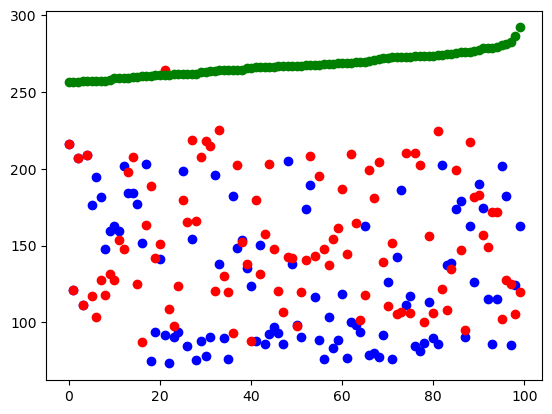

In [148]:
plt.figure()
plt.scatter(range(0,len(y1)),y1,color = 'b')
plt.scatter(range(0,len(y2)),y2,color = 'r')
plt.scatter(range(0,len(y)),y,color = 'g')
plt.show()

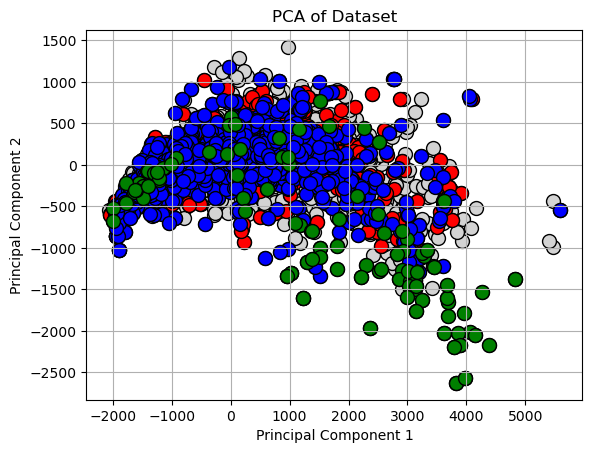

In [38]:
x = np_data[featureNames]
y = np_data[targetNames]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

Al_df = np_data[np_data['type'].isin(name1)]
Al_df = Al_df[featureNames]
Al_pca = pca.fit_transform(Al_df)

Rd_df = np_data[np_data['type'].isin(name2)]
Rd_df = Rd_df[featureNames]
Rd_pca = pca.fit_transform(Rd_df)

top_100 = np_data[np_data['logSelfD'].isin(y_best)]
top_100 = top_100[featureNames]

# Find the indices of x1 and x2 in X
x1_indices = x.reset_index().merge(Al_df, how='inner', on=list(x.columns)).set_index('index').index
x2_indices = x.reset_index().merge(Rd_df, how='inner', on=list(x.columns)).set_index('index').index
x3_indices = x.reset_index().merge(top_100, how='inner', on=list(x.columns)).set_index('index').index

fig = plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgrey', edgecolor='k', s=100, label='Other points')

plt.scatter(X_pca[x2_indices, 0], X_pca[x2_indices, 1], c='red', edgecolor='k', s=100, label='Subset x2')
plt.scatter(X_pca[x1_indices, 0], X_pca[x1_indices, 1], c='blue', edgecolor='k', s=100, label='Subset x1')
plt.scatter(X_pca[x3_indices, 0], X_pca[x3_indices, 1], c='green', edgecolor='k', s=100, label='best y')
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(scatter, label='Class Label')  # Add a color bar for class labels if available
plt.grid(True)
plt.show()

In [58]:
# for i in range(5,100,5):
#     Al_df = np_data[np_data['type'].isin(name1[0:i])]
#     Al_df = Al_df[featureNames]
#     Al_pca = pca.fit_transform(Al_df)
#     x1_indices = x.reset_index().merge(Al_df, how='inner', on=list(x.columns)).set_index('index').index
#     fig = plt.figure()
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgrey', edgecolor='k', s=100, label='Other points')
#     scatter_x1 = plt.scatter(X_pca[x1_indices, 0], X_pca[x1_indices, 1], c='blue', edgecolor='k', s=100, label='Subset x1')
#     plt.title('PCA of Dataset')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')

#     plt.grid(True)
#     plt.show()
    

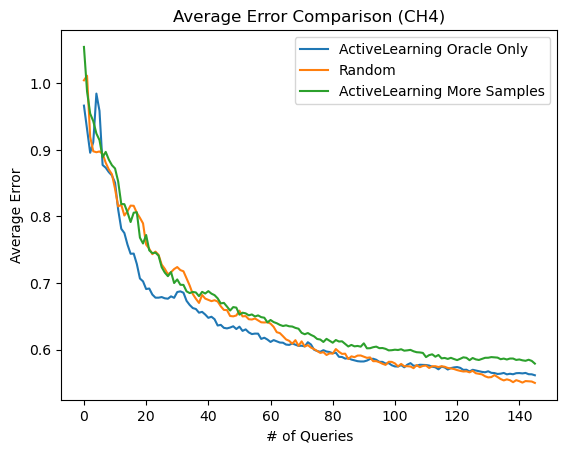

In [25]:
df1 = pd.read_csv('./ALresults/AL_ch4_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_ch4_150_full.csv')
df3 = pd.read_csv('./ALresults/AL_ch4_150_more_samples2.csv')

df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning More Samples')
#plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison (CH4)')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

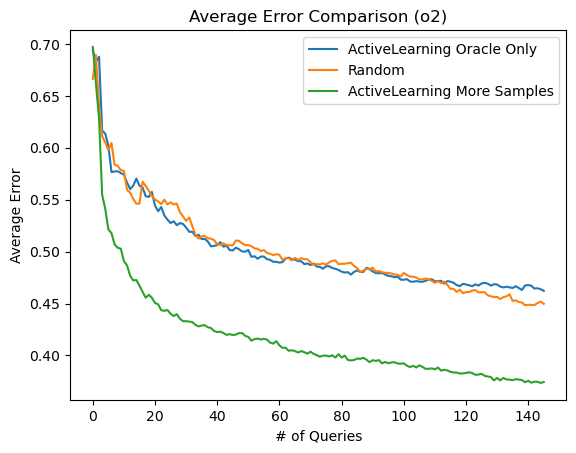

In [72]:
# Oxygen Only
df1 = pd.read_csv('./ALresults/AL_o2n2_150_oracle_only_cat.csv')
df2 = pd.read_csv('./ALresults/Rd_o2n2_150_full.csv')
df3 = pd.read_csv('./ALresults/AL_o2n2_150_more_samples.csv')

df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning More Samples')
#plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison (o2)')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

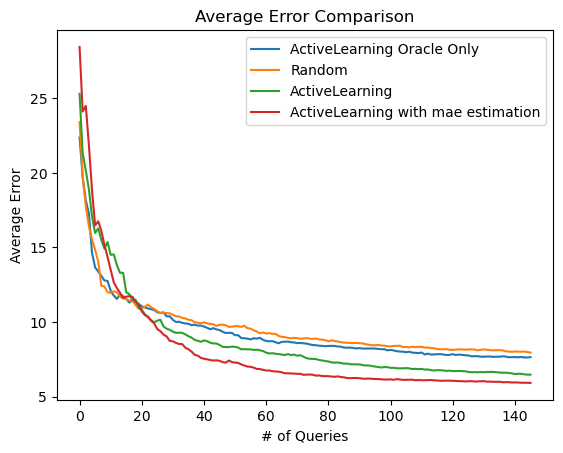

In [105]:
df1 = pd.read_csv('./ALresults/AL_meth_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_meth_100_full.csv')
df3 = pd.read_csv('./ALresults/AL_meth_150_more_samples.csv')
df4 = pd.read_csv('./ALresults/AL_meth_150_more_samples_mae_est.csv')



df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]


plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning')
plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

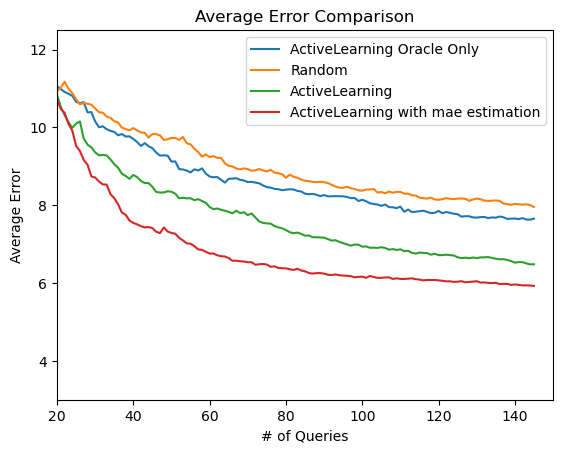

In [106]:
df1 = pd.read_csv('./ALresults/AL_meth_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_meth_100_full.csv')
df3 = pd.read_csv('./ALresults/AL_meth_150_more_samples.csv')
df4 = pd.read_csv('./ALresults/AL_meth_150_more_samples_mae_est.csv')


df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning')
plt.plot(df4, label='ActiveLearning with mae estimation')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
plt.ylim(3,12.5)
plt.xlim(20,150)
plt.legend()
plt.show()

   sizeOfTrainingSet  averageError  stdErrorOfMeanError  \
0                  5      3.736963             0.437900   
1                  6      3.553431             0.400896   
2                  7      3.583923             0.556732   
3                  8      3.450646             0.482377   
4                  9      3.387176             0.438661   

   stdDeviationOfMeanError  
0                 0.979173  
1                 0.981989  
2                 1.472973  
3                 1.364368  
4                 1.315983  


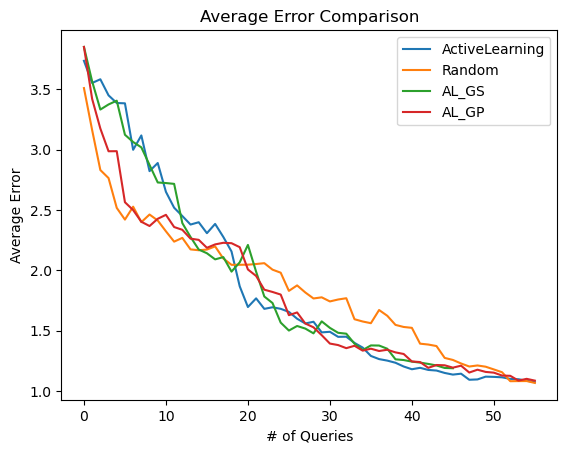

In [79]:
df1 = pd.read_csv('./ALresults/All_zifs/AL_500.csv')
df2 = pd.read_csv('./ALresults/All_zifs/Rd_500.csv')
df3 = pd.read_csv('./ALresults/AL_meth_100_bs.csv')
df4 = pd.read_csv('./ALresults/All_zifs/AL_500_gp.csv')


print(df1.head())
df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning')
plt.plot(df2, label='Random')
plt.plot(df3, label='AL_GS')
plt.plot(df4, label='AL_GP')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
#plt.ylim(0,9)
#plt.xlim(0,100)
plt.legend()
plt.show()